In [234]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn import svm

import matplotlib.pyplot as plt

In [235]:
# utility function to read from a text file
def read_file(filename):
    with open(filename) as file:
        lines = file.readlines()
        clean = [x.strip().lower() for x in lines if x.strip()!=""]
        return clean

In [236]:
# prapares the dataset.
from functools import reduce
from math import gcd

def prepare_dataset(balance=False):
    sentence = 'sentence'
    category = 'category'
    def prepare_df(file):
        df = pd.read_csv(file, header=None, names=[sentence, category])
        return df
    
    main_df = None
    
    df = prepare_df('dataset.csv')
    categories = df[category].value_counts()
    
    gcd_num = reduce(gcd, list(categories))
    all_multp = reduce(lambda a, b: a*b, categories)
    common_multiplier = all_multp // gcd_num

    for cat, count in zip(categories.index, categories):
        cat_df = df[df[category]==cat]
        
        for _ in range(common_multiplier//count):
            if main_df is None:
                main_df = cat_df.copy()
            else:
                main_df = main_df.append(cat_df.copy(), ignore_index=True)

    return main_df

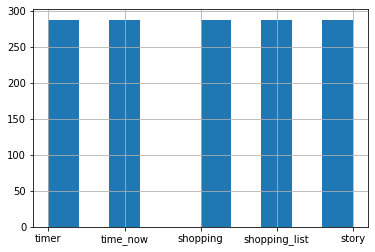

In [237]:
df = prepare_dataset(True)

df['category'].hist()

In [238]:
def assertions(model, vectorizer):
    sents = []
    predictions = []
    results = []
    y_true = []
    
    def run(items):
        for item in items:
            sent, label = item
            pred = predict(sent, model, vectorizer)[0]
            
            result = 'Correct' if pred == label else 'Incorrect'
            sents.append(sent)
            predictions.append(pred)
            y_true.append(label)
            results.append(result)
            
    items = [
        ('add milk to my shopping list sophia', 'shopping'),
        ('can you tell me sophia what time it is', 'time_now'),
        
    ]
    
    run(items)
    
    df = pd.DataFrame()
    df['Sentences'] = sents
    df['Predictions'] = predictions
    df['Expect'] = y_true
    df['Results'] = results
    
    return df

In [239]:
def predict(sentences, model, vectorizer):
    sentences = sentences if isinstance(sentences, list) else [sentences]
    vector = vectorizer.transform(sentences)
    return model.predict(vector)

def save_models(
    model, 
    vectorizer,    
    model_name = 'model.pickle',
    vector_name = 'vector.pickle'
):
    pickle.dump(model, open(model_name, 'wb'))
    pickle.dump(vectorizer, open(vector_name, 'wb'))

In [240]:
score_funcs = [
    ('Accuracy', accuracy_score),
#     ('Precision', lambda y, y_pred: precision_score(y, y_pred, average='weighted')),
#     ('Recall', lambda y, y_pred: recall_score(y, y_pred, average=None)),
    ('F1 Score', lambda y, y_pred: f1_score(y, y_pred, average='macro'))
]

model_scores = dict()

def train_and_test(model, vectorizer, score_func_list=score_funcs, model_name=None):
    fold = KFold(n_splits=4, random_state=10, shuffle=True)
    
    feature_col = 'sentence'
    target_col = 'category'
    
    X = df[[feature_col]]
    y = df[target_col]
    
    scores = dict()
    for (name, func) in score_func_list:
        scores[name] = [] 
    
    for train_index, test_index in fold.split(X):
        X_train, X_test = X.loc[ train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        X_train_matrix = vectorizer.fit_transform(X_train[feature_col])
        model.fit(X_train_matrix, y_train)
        
        X_test_matrix = vectorizer.transform(X_test[feature_col])
        y_pred = model.predict(X_test_matrix)
        # print(sum(y_pred), sum(y_test))

        for (name, func) in score_func_list: 
            score = func(y_test, y_pred)
            scores[name].append(score)

    if model_name != None:
        model_scores[model_name] = []
        
    for (name, func) in score_func_list:
        avg_score = np.mean(scores[name])
        print(name, ': ', avg_score)
        
        if model_name != None:
            model_scores[model_name].append(avg_score)
        
    
    return assertions(model, vectorizer)

In [241]:
df = prepare_dataset()

In [242]:
model1 = svm.SVC(gamma='auto')
vectorizer = CountVectorizer()

train_and_test(model1, vectorizer, model_name='SVC')

Accuracy :  1.0
F1 Score :  1.0


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,shopping,shopping,Correct
1,can you tell me sophia what time it is,time_now,time_now,Correct


In [243]:
model2 = svm.SVC(gamma='auto')
vectorizer = TfidfVectorizer(ngram_range=(1, 4))

train_and_test(model2, vectorizer, model_name='SVC')

Accuracy :  1.0
F1 Score :  1.0


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,shopping,shopping,Correct
1,can you tell me sophia what time it is,time_now,time_now,Correct


In [244]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
vectorizer = CountVectorizer()

train_and_test(nb, vectorizer, model_name='MultinomialNB')

Accuracy :  1.0
F1 Score :  1.0


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,shopping,shopping,Correct
1,can you tell me sophia what time it is,time_now,time_now,Correct


In [245]:
from sklearn.linear_model import SGDClassifier

sgd_model1 = SGDClassifier()
vectorizer = CountVectorizer()

train_and_test(sgd_model1, vectorizer, model_name='SGDClassifier')

Accuracy :  1.0
F1 Score :  1.0


,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,shopping,shopping,Correct
1,can you tell me sophia what time it is,time_now,time_now,Correct


In [246]:
from sklearn.linear_model import LogisticRegression

regr = LogisticRegression(solver='lbfgs')
vectorizer = CountVectorizer()

train_and_test(regr, vectorizer, model_name='LogisticRegression')


Accuracy :  1.0
F1 Score :  1.0


/Users/msarica/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/msarica/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/msarica/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/msarica/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarni

,Sentences,Predictions,Expect,Results
0,add milk to my shopping list sophia,shopping,shopping,Correct
1,can you tell me sophia what time it is,time_now,time_now,Correct


In [247]:
def show_model_results():
    score_df = pd.DataFrame(model_scores)
    score_df.index = [name for name, _ in score_funcs]
    score_df = score_df.T
    score_df.sort_values(by='Accuracy', inplace=True, ascending=False)
    return score_df

show_model_results()
# model_scores

,Accuracy,F1 Score
SVC,1.0,1.0
MultinomialNB,1.0,1.0
SGDClassifier,1.0,1.0
LogisticRegression,1.0,1.0


In [248]:
# saving models to be used by the server
save_models(
    sgd_model1, 
    vectorizer,
    model_name='model2/model.pickle',
    vector_name='model2/vector.pickle'
)